In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(42)

df = pd.read_csv("all_stocks_5yr.csv")
df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


### Data Cleaning
Slecting stocks that have full data from 2013-2018

In [3]:
## Ensuring that each stock has 1259 rows of data (2013-02-08 to 2018-02-07, 252 * 5 -1)
df_cleaned = df.groupby('Name').filter(lambda x: len(x) == 1259)

## Number of stocks left
print("Number of stocks with full data = ", df_cleaned['Name'].nunique())
df_cleaned.info()

Number of stocks with full data =  470
<class 'pandas.core.frame.DataFrame'>
Index: 591730 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    591730 non-null  object 
 1   open    591728 non-null  float64
 2   high    591728 non-null  float64
 3   low     591728 non-null  float64
 4   close   591730 non-null  float64
 5   volume  591730 non-null  int64  
 6   Name    591730 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 36.1+ MB


In [4]:
### Look at the rows with NA in open, high and low (it is fine to ignore for baseline model which only looks at close)
rows_with_na = df_cleaned[df_cleaned.isna().any(axis=1)]
rows_with_na

,date,open,high,low,close,volume,Name
478594,2015-06-09,NaN,NaN,NaN,526.09,12135,REGN
581906,2015-05-12,NaN,NaN,NaN,124.08,569747,VRTX


### Data Splitting  

**Training Set:** Data from `2013-02-08` to `2017-02-07`  
**Testing Set:** Data from `2017-02-08` to `2018-02-07`

In [6]:
# Define date ranges for training and testing set
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

train_start = pd.Timestamp("2013-02-08")
train_end   = pd.Timestamp("2017-02-07")

test_start  = pd.Timestamp("2017-02-08")
test_end    = pd.Timestamp("2018-02-07")

# Split the df to train and test accordingly
train_df = df_cleaned[(df_cleaned['date'] >= train_start) & (df_cleaned['date'] <= train_end)]
test_df  = df_cleaned[(df_cleaned['date'] >= test_start)  & (df_cleaned['date'] <= test_end)]

### Baseline: Markowitz mean–variance optimization

In [8]:
# Selecting relevant columns and computing returns
returns_df = train_df.pivot(index='date', columns='Name', values='close').sort_index()
returns_df = returns_df.pct_change().dropna()

returns_df

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.010648,-0.019661,-0.006464,0.010422,-0.011034,-0.002772,-0.004359,-0.003274,-0.012270,0.008315,...,0.002479,-0.001333,-0.003724,-0.000700,0.003769,0.013658,-0.011485,-0.002637,0.002900,0.006354
2013-02-12,0.000448,-0.013140,0.002679,-0.025067,-0.011994,0.004277,0.001168,0.004106,0.006470,0.004123,...,0.003532,0.003203,0.002039,0.000700,-0.003755,0.017844,0.003098,-0.002776,0.011565,0.014432
2013-02-13,0.002913,0.027330,0.004707,-0.001903,-0.004235,-0.006814,0.004665,0.002590,-0.002057,-0.000216,...,0.000352,0.005854,0.002374,0.004899,0.005025,0.011091,-0.005251,0.007423,0.010208,-0.005631
2013-02-14,-0.003799,-0.045703,-0.001646,-0.000899,0.036859,0.002787,0.006965,-0.005846,-0.005153,0.006053,...,-0.007037,0.016931,-0.001692,-0.003946,0.003750,0.007431,-0.008073,0.004474,-0.004446,-0.008346
2013-02-15,-0.052266,0.036455,0.002029,-0.013780,0.027618,-0.003635,0.010951,0.014085,0.000648,-0.007843,...,0.015946,-0.008325,-0.001808,-0.002564,-0.007472,-0.006674,0.001565,-0.005764,-0.011774,0.021341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-01,0.005922,-0.004520,-0.022224,0.060981,-0.003600,0.015238,0.013407,-0.005796,-0.000176,0.016413,...,0.009582,-0.013918,-0.011324,0.003527,0.020202,-0.003245,-0.010072,0.001521,0.006400,0.006917
2017-02-02,-0.007308,-0.000908,0.010897,-0.001709,0.000000,-0.006320,0.009922,0.003798,-0.001764,-0.012341,...,0.026628,0.013068,0.006149,-0.006678,0.014144,-0.007121,0.012332,-0.007510,-0.016251,0.006869
2017-02-03,0.009816,0.004317,0.002526,0.004279,-0.003613,0.013969,0.000702,0.007480,0.017762,0.003855,...,-0.007447,0.001376,0.001078,0.010970,-0.002789,0.009221,0.008527,0.004421,0.036869,0.003950


#### Calculate mean and covariance from training set

In [10]:
daily_mean_returns = returns_df.mean()
daily_cov_returns = returns_df.cov()

# Annualized
mean_returns = daily_mean_returns * 252
cov_returns = daily_cov_returns * 252

In [11]:
target_return = 0.15

## Optimization variables
weights = cp.Variable(470)
objective = cp.Minimize(cp.quad_form(weights, cov_returns))

## Constraints
constraints = [
    cp.sum(weights) == 1,              
    weights >= 0,                      # no shorting
    mean_returns.values @ weights >= target_return
]

## Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get weights
optimal_weights = pd.Series(weights.value, index=mean_returns.index)

print("Optimised Weights:")
print(optimal_weights)
print(f"Expected Returns: {optimal_weights @ mean_returns:.2%}")
print(f"Volitility: {np.sqrt(np.dot(optimal_weights.T, cov_returns @ optimal_weights)):.2%}")

Optimised Weights:
Name
A      -1.256709e-23
AAL     2.602501e-23
AAP    -6.722648e-23
AAPL    1.370599e-02
ABBV   -8.034901e-23
            ...     
XYL    -3.935485e-23
YUM    -1.405044e-22
ZBH    -4.517773e-23
ZION    2.623390e-23
ZTS     3.746080e-23
Length: 470, dtype: float64
Expected Returns: 15.00%
Volitility: 9.52%


#### Testing

In [13]:
returns_test = test_df.pivot(index='date', columns='Name', values='close').sort_index()
returns_test = returns_test.pct_change().dropna()

## Cummulative returns with the optimised weights
portfolio_returns = returns_test @ optimal_weights
cumulative_portfolio_returns = np.cumprod(1 + portfolio_returns.values)

print("Realized Return: {}".format(cumulative_portfolio_returns[-1]-1))

Realized Return: 0.14833346630475996


In [14]:
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
print("Sharpe ratio:  ", sharpe_ratio)

Sharpe ratio:   1.9858935710203929


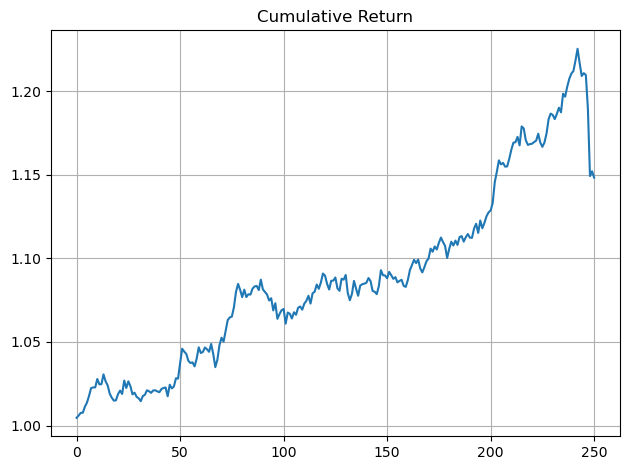

In [15]:
plt.plot(cumulative_portfolio_returns)
plt.title("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()